In [1]:
import sys
sys.path.append('../')

import numpy as np
import time
from datetime import datetime
import copy
from tqdm import tqdm
import os
import matplotlib as mpl
from matplotlib import pyplot as plt

import importlib
import EnsembleLib
importlib.reload(EnsembleLib)
from EnsembleLib import time_diff

import auxFuncs
from auxFuncs import matrix_sqrt
from auxFuncs import makeCorrelatedMatrix
importlib.reload(auxFuncs)

import DatasetMaker
importlib.reload(DatasetMaker)
import Experiments
importlib.reload(Experiments)

from collections import OrderedDict

import torch
from torch.optim import SGD, Adam, lr_scheduler
device = 'cuda'

import pytz
from datetime import datetime
from dateutil.relativedelta import relativedelta
tz = pytz.timezone('US/Eastern')
from scipy.stats import ortho_group


def time_now():
    return datetime.now(tz)

def time_diff(t_a, t_b):
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

def remove_duplicates(arr):
    """
    Remove duplicates from a 1D numpy array.

    Parameters:
    - arr: 1D numpy array

    Returns:
    - unique_arr: 1D numpy array with duplicates removed
    """
    unique_arr = np.unique(arr)
    return unique_arr

KeyboardInterrupt: 

In [ ]:
import os
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from torchvision.models import resnext50_32x4d
from tqdm import tqdm

In [39]:
#Width and height of axes.
w=1.5
h=1.5

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rcParams.update({'font.size': MEDIUM_SIZE, 'figure.figsize': [w,h]})

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['legend.title_fontsize'] = SMALL_SIZE

#Helper Function for setting figure size by axis size.
#set_size(w,h,ax)
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    

In [40]:
def makeImageNetSubset(train_folder_path, test_folder_path, num_classes=10, imagesPerClass=None):

    def process_folder(folder_path, description):
        # Check for sufficient images in each class folder
        class_folders = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
        if len(class_folders) < num_classes:
            raise ValueError(f"Not enough class folders in {description}. Found {len(class_folders)}, required {num_classes}.")

        for class_folder in class_folders[:num_classes]:
            num_images = len(os.listdir(os.path.join(folder_path, class_folder)))
            if imagesPerClass and num_images < imagesPerClass:
                raise ValueError(f"Class {class_folder} in {description} has only {num_images} images, which is less than the required {imagesPerClass}.")

        # Create dataset
        tqdm.write(f"Imaging {description}...")
        dataset = datasets.ImageFolder(folder_path, transform=transform)
        
        # Filter dataset
        label_to_indices = {label: [] for label in range(num_classes)}
        for i, (_, label) in enumerate(dataset):
            if label < num_classes:
                label_to_indices[label].append(i)

        final_indices = []
        for label in range(num_classes):
            if imagesPerClass:
                final_indices.extend(label_to_indices[label][:imagesPerClass])
            else:
                final_indices.extend(label_to_indices[label])

        final_subset = Subset(dataset, final_indices)
        dataloader = DataLoader(final_subset, batch_size=32, shuffle=True)
        
        print('Dataset Filtered', flush = True)

        features_list, labels_list = [], []
        with torch.no_grad():
            for imgs, labels in tqdm(dataloader, desc=f'Extracting features from {description}'):
                imgs = imgs.cuda()
                features = feature_extractor(imgs)
                features = features.view(features.size(0), -1)
                features_list.append(features)
                labels_list.append(labels)

        features_tensor = torch.cat(features_list, dim=0)
        labels_tensor = torch.cat(labels_list, dim=0)
        labels_tensor = torch.nn.functional.one_hot(labels_tensor, num_classes)
        
        print(f"Total images in {description}: {features_tensor.shape[0]}")
        
        return features_tensor, labels_tensor

    # Check if num_classes is within the allowed limit
    if num_classes > 10:
        raise ValueError("num_classes cannot be larger than 10.")
    
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Loading the pretrained ResNeXt model
    model = resnext50_32x4d(pretrained=True).cuda()

    # Remove the classifier layer
    feature_extractor = torch.nn.Sequential(*(list(model.children())[:-1]))

    # Place the feature extractor in evaluation mode
    feature_extractor.eval()

    train_features, train_labels = process_folder(train_folder_path, "Training set")
    test_features, test_labels = process_folder(test_folder_path, "Test set")

    return train_features, train_labels, test_features, test_labels

In [41]:
# Usage
datasetname = 'imagewoof2'
architecture = 'ResNext'
destination = '../DataTensors'
train_folder_path = f'{datasetname}/train'
test_folder_path = f'{datasetname}/val'
num_classes = 10
# train_features, train_labels, test_features, test_labels = makeImageNetSubset(train_folder_path, test_folder_path, num_classes)

In [42]:
# #Save tensors to disk after moving them to CPU
# torch.save(train_features.cpu(), f'{destination}/{architecture}_{datasetname}_train_features.pt')
# torch.save(train_labels.cpu(), f'{destination}/{architecture}_{datasetname}_train_labels.pt')

# torch.save(test_features.cpu(), f'{destination}/{architecture}_{datasetname}_test_features.pt')
# torch.save(test_labels.cpu(), f'{destination}/{architecture}_{datasetname}_test_labels.pt')

In [43]:
#Reload tensors from saved location
train_features = torch.load(f'{destination}/{architecture}_{datasetname}_train_features.pt')
train_labels = torch.load(f'{destination}/{architecture}_{datasetname}_train_labels.pt')

test_features = torch.load(f'{destination}/{architecture}_{datasetname}_test_features.pt')
test_labels = torch.load(f'{destination}/{architecture}_{datasetname}_test_labels.pt')

In [44]:
train_features.shape

torch.Size([9025, 2048])

In [45]:
test_features.shape

torch.Size([3929, 2048])

In [46]:
# Assuming all_features and all_labels are the tensors you got from the previous function
#class_names = ['tench', 'English springer', 'cassette player', 'chain saw', 'church', 
#               'French horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']

class_names = ['Australian terrier', 'Border terrier', 'Samoyed', 'Beagle', 'Shih-Tzu', 'English foxhound', 'Rhodesian ridgeback', 'Dingo', 'Golden retriever']

In [47]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def display_feature_examples(all_features, all_labels, num_classes, class_names, num_examples_per_class=5, saveFig = False, fig_name = 'Features'):
    # Group feature vectors by class label
    class_to_features = defaultdict(list)
    all_labels = torch.argmax(all_labels, dim = 1)
    for features, label in zip(all_features, all_labels):
        class_to_features[label.item()].append(features)

    # Prepare the subplots grid
    fig, axs = plt.subplots(num_examples_per_class + 1, num_classes, figsize=(15, 10))

    colorbar_added = False
    cax = None

    # Loop through each class and its corresponding feature vectors
    for class_idx in range(num_classes):
        features_for_class = class_to_features[class_idx]

        # Add class label above the column with newlines between words
        multi_line_title = '\n'.join(class_names[class_idx].split(' '))
        axs[0, class_idx].set_title(multi_line_title)

        # Randomly select feature vectors to display
        selected_features = np.random.choice(len(features_for_class), size=num_examples_per_class, replace=False)
        
        # Display feature vectors
        for row_idx, feature_idx in enumerate(selected_features):
            feature_vector = features_for_class[feature_idx]
            feature_image = feature_vector.cpu().numpy()
            feature_image = feature_image.reshape(32, 64)  # Reshape into a 32x64 rectangle

            im = axs[row_idx, class_idx].imshow(feature_image, cmap='viridis')
            axs[row_idx, class_idx].axis('off')

            if not colorbar_added:
                cax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
                fig.colorbar(im, cax=cax)
                colorbar_added = True

        # Display one-hot encoding below the feature vectors
        one_hot = np.zeros(num_classes)
        one_hot[class_idx] = 1
        axs[-1, class_idx].imshow(one_hot.reshape(1, -1), cmap='viridis', aspect=1)
        axs[-1, class_idx].axis('off')
    
    if saveFig:
        plt.savefig(fig_name+".svg", format="svg", dpi=300)
    plt.show()


In [48]:
# Assuming all_features and all_labels are the tensors you got from the previous function
#display_feature_examples(features, labels, num_classes, class_names, num_examples_per_class=5, saveFig=True, fig_name='WoofFeatures')

Data-Data covariance matrix and feature-feature covariance matrix

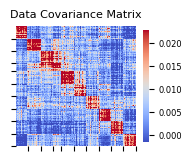

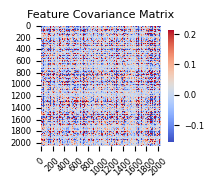

In [49]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cutoffPercent = 5
features = train_features
labels = train_labels

# Generate random data matrix (P x M) and label matrix (P x C)
P = features.shape[0]
M = features.shape[1]
C = labels.shape[1]

# Sort data matrix by category
_, indices = torch.max(labels, dim=1)
sorted_indices = torch.argsort(indices)
sorted_features = features[sorted_indices]

# Calculate P x P covariance matrix
mean_P = torch.mean(sorted_features, dim=1, keepdim=True)
cov_P_by_P = (1 / P) * (sorted_features - mean_P) @ (sorted_features - mean_P).T

# Calculate percentiles for P x P covariance matrix
p1_P, p99_P = np.percentile(cov_P_by_P.detach().numpy(), [cutoffPercent, 100-cutoffPercent])

# Calculate M x M covariance matrix
mean_M = torch.mean(features, dim=0, keepdim=True)
cov_M_by_M = (1 / M) * (features - mean_M).T @ (features - mean_M)
# Calculate percentiles for M x M covariance matrix
p1_M, p99_M = np.percentile(cov_M_by_M.detach().numpy(), [cutoffPercent, 100-cutoffPercent])

# Find class boundaries for P x P plot
unique_indices, class_boundaries = torch.unique(indices, sorted=True, return_counts=True)
class_boundaries = class_boundaries.cumsum(0).tolist()

# Plot P x P covariance matrix
fig, ax = plt.subplots()
sns.heatmap(cov_P_by_P.detach().numpy(), cmap="coolwarm", annot=False, vmin=p1_P, vmax=p99_P, cbar_kws={"shrink": 0.75}, ax=ax)
ax.set_aspect('equal')  # This line ensures the aspect ratio is equal for the x and y axes
plt.xticks(class_boundaries, labels=None, rotation=45)
plt.yticks(class_boundaries, labels=None, rotation=0)
plt.title('Data Covariance Matrix')
set_size(w, h)
plt.savefig(f'{architecture}_{datasetname}_PPCov.png', dpi=300, bbox_inches = 'tight')
plt.show()

# Determine tick marks for M x M plot
ticks_M = np.arange(0, M, 200)

# Plot M x M covariance matrix
fig, ax = plt.subplots()
sns.heatmap(cov_M_by_M.detach().numpy(), cmap="coolwarm", annot=False, vmin=p1_M, vmax=p99_M, cbar_kws={"shrink": 0.75}, ax=ax)
ax.set_aspect('equal')  # This line ensures the aspect ratio is equal for the x and y axes
plt.xticks(ticks_M, labels=ticks_M.tolist(), rotation=45)
plt.yticks(ticks_M, labels=ticks_M.tolist(), rotation=0)
plt.title('Feature Covariance Matrix')
set_size(w, h)
plt.savefig(f'{architecture}_{datasetname}_MMCov.png', dpi=300, bbox_inches = 'tight')
plt.show()

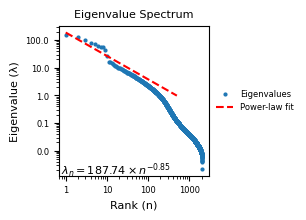

In [52]:
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit

# Function to model the power-law relationship
def power_law(x, a, b):
    return a*x**b

# Calculate eigenvalues of the M x M covariance matrix
eigvals_M = torch.linalg.eigvalsh(cov_M_by_M)
sorted_eigvals_M = torch.flip(eigvals_M, [0])  # Sort in descending order

# Generate indices (ranks)
indices = torch.arange(1, M + 1)

# Select a subset of top N eigenvalues for fitting
N = 500
fit_indices = indices[:N].numpy()
fit_eigvals = sorted_eigvals_M[:N].numpy()

# Fit the subset to a power law in log-log scale
params, _ = curve_fit(power_law, fit_indices, fit_eigvals)

# Create log-log plot
plt.figure()

# Eigenvalue dots
plt.loglog(indices.numpy(), sorted_eigvals_M.numpy(), 'o', markersize=2, label='Eigenvalues')
# Power-law fit
plt.loglog(fit_indices, power_law(fit_indices, *params), 'r--', linewidth=1.5, label='Power-law fit')

# Place the fit parameters text at the bottom-left corner of the plot area
ax = plt.gca()
x_text_position = ax.get_xlim()[0] * 1.1  # Shift a little from the left edge for better aesthetics
y_text_position = ax.get_ylim()[0] * 1.1  # Shift a little from the bottom edge for better aesthetics
plt.text(x_text_position, y_text_position, rf'$\lambda_n = {params[0]:.2f} \times n^{{{params[1]:.2f}}}$')

# Adjusting the ticks
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
plt.gca().xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=5))
plt.gca().yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=5))

# Title and labels
plt.title('Eigenvalue Spectrum')
plt.xlabel('Rank (n)')
plt.ylabel('Eigenvalue (λ)')

# Position the legend to the right of the axes
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Applying custom size function
set_size(w, h, ax)

# Saving the plot in SVG format
#plt.tight_layout()
plt.savefig(f'{architecture}_{datasetname}_spectrum.svg', dpi=300, bbox_inches='tight')
plt.show()